In [1]:
import pandas as pd
import numpy as np
import time
from utils import dfwellgr,marker_ssig,extract_signature_Xy,plot_simple,dfwellgr
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(42)

In [2]:
def run_prediction(myrocket,intervals,df_test_tops, df_test_log, use_constraint=True,confidence_level=0.96,verbose=0):
    start = time.time()
    df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))
    for well in tqdm(df_test_tops.index, desc=f"Processing Wells"):
        pred_m, df_wm = get_markers_rocket_order_with_constraint(well,f_mean, f_std,intervals, df_test_log, pred_column, wsize, input_variable, 
                                             s2s = False,
                                             model = None, 
                                             xgb = True,
                                             rocket = myrocket, 
                                             classifier_xgb = classifier_xgb, 
                                             classifier = classifier,
                                             constraint = use_constraint,
                                            )
        row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
        row_df = pd.DataFrame([row])
        df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")
        
    ext = time.time() - start
    print(f'🍺 Total prediction time {ext}')
    df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
    df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
    df_tops_pred = df_tops_pred.set_index('wellName')
    return df_tops_pred

### Importing Data

***About the Data***
Parquet Data: columnar type of data
- Training
1. logs.parquet: wellName, DEPTH,GR --> X_data
2. loc.parquet: wellName, Latitude, Longitude -->X_data
3. tops.parquet: wellName, depth of 3 different marker ['MARCEL', 'SYLVAIN', 'CONRAD'], wellName is unique here(no duplication) ---> y

Goal: using GR as input variable and predict the marker of a given depth 

In [3]:
#LOAD DATA
df_tops = pd.read_parquet('Training/tops.parquet', engine='fastparquet')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_tops = df_tops[cols]
df_tops.dropna(inplace = True)
df_tops[df_tops['CONRAD'] - df_tops['SYLVAIN'] < 0] #Here we can see incorrect data

,MARCEL,SYLVAIN,CONRAD
wellName,,,
512325378.0,6509.0,6794.0,6792.0
512330897.0,6351.0,6617.0,6367.0


In [4]:
df_loc = pd.read_parquet('Training/loc.parquet', engine='fastparquet').reset_index()
df_log = pd.read_parquet('Training/logs.parquet', engine='fastparquet') #read parquet as DataFrame
df_log.loc[df_log['GR'] < -1, 'GR' ] = -1 #when GR<-1, change it to -1

df_log = df_loc.merge(df_log, how = 'inner', left_on = 'wellName', right_on = 'wellName') #merge loc info and depth info
df_log.head()

,wellName,Latitude,Longitude,DEPTH,GR
0,512320698.0,48.673353,2.145178,421.0,96.9752
1,512320698.0,48.673353,2.145178,421.5,102.3324
2,512320698.0,48.673353,2.145178,422.0,104.6432
3,512320698.0,48.673353,2.145178,422.5,99.2187
4,512320698.0,48.673353,2.145178,423.0,92.0200


In [5]:
# Load the training_well array from the file which contains the wells with good signature cluster
#shape (3,1)
well_array = np.load('hackaton_training_well_one.npy', allow_pickle=True)

### Visulization(TO BE COMPLETED)

/var/folders/gj/m7pys2v95k19_b1dkf01nl5r0000gn/T/ipykernel_2949/1894778136.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['DEPTH'].apply(lambda x: apply_label(wellName, x, df_log, df_tops))
/var/folders/gj/m7pys2v95k19_b1dkf01nl5r0000gn/T/ipykernel_2949/1894778136.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['DEPTH'].apply(lambda x: apply_label(wellName, x, df_log, df_tops))


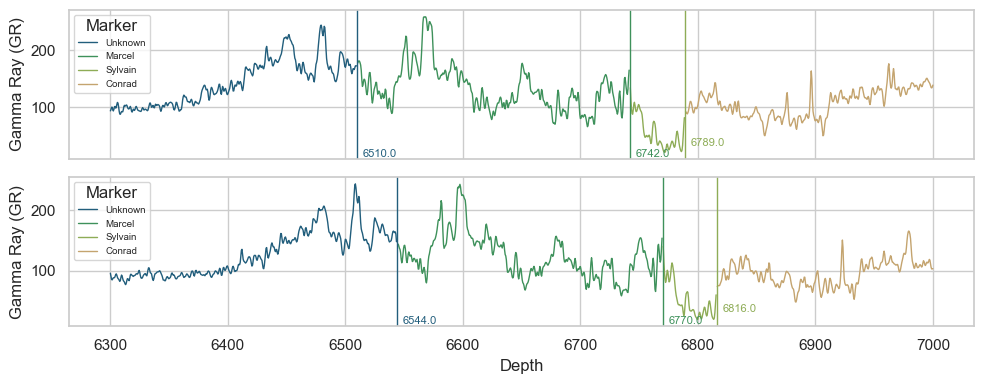

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def apply_label(wellName, d, df_log, df_tops):
    depths = df_tops[df_tops.index == wellName].values[0]
    if d < depths[0]:
        return 'Unknown'
    elif d > depths[0] and d < depths[1]:
        return 'Marcel'
    elif d > depths[1] and d < depths[2]:
        return 'Sylvain'
    elif d > depths[2]:
        return 'Conrad'

def plot_multiple(wellNames, df_log, df_tops):
    """
    Plot original time series data for GR and Depth and the marker positions for chosen wells.
    """

    sns.set(style="whitegrid")

    # Create a color palette
    palette = sns.color_palette("gist_earth", 4)

    # Create a subplot for each well
    fig, axes = plt.subplots(nrows=len(wellNames), ncols=1, figsize=(10, len(wellNames) * 2), sharex=True)

    for idx, wellName in enumerate(wellNames):
        # Data filtering and processing
        filtered_df = df_log[df_log['wellName'] == wellName]
        depths = df_tops[df_tops.index == wellName].values[0]
        filtered_df = df_log[(df_log['wellName'] == wellName) & (df_log['DEPTH'] >= 6300) & (df_log['DEPTH'] <= 7000)]
        filtered_df.loc[filtered_df['GR'] == -1, 'GR'] = filtered_df['GR'].mean()
        filtered_df['label'] = filtered_df['DEPTH'].apply(lambda x: apply_label(wellName, x, df_log, df_tops))

        # Plotting seaborn lineplot
        sns.lineplot(ax=axes[idx], data=filtered_df, x='DEPTH', y='GR', hue='label', palette=palette, legend=True, linewidth=1)

        # Plotting horizontal lines for starting depth
        previous_depth = 0
        offset_increment = 20

        for depth, color in zip(depths, palette):
            axes[idx].axvline(x=depth, color=color, linestyle='-', linewidth=1, alpha=1)
            offset = 0 if depth - previous_depth > 50 else offset_increment  # Adjust conditions based on your data scale
            y_position = axes[idx].get_ylim()[0] + offset
            axes[idx].text(depth + 5, y_position, f'{depth}', color=color, verticalalignment='bottom', fontsize=8, alpha=1)
            previous_depth = depth

        # axes[idx].set_title(f'Gamma Ray (GR) vs Depth for Well {wellName}')
        axes[idx].set_xlabel('Depth')
        axes[idx].set_ylabel('Gamma Ray (GR)')
        axes[idx].legend(title='Marker', fontsize=7)
    

    plt.tight_layout()
    # plt.legend(title='Marker', fontsize=8)
    plt.show()

# Example usage
well_names = [512320971,512320970]  
plot_multiple(well_names, df_log, df_tops)


/Users/w_yy_ccc/Desktop/CRP_TimeSeriesClassification/utils.py:234: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(data=filtered_df, x='DEPTH', y='GR', hue='label', palette=palette, legend='full', alpha=0.5,linewidth=1)


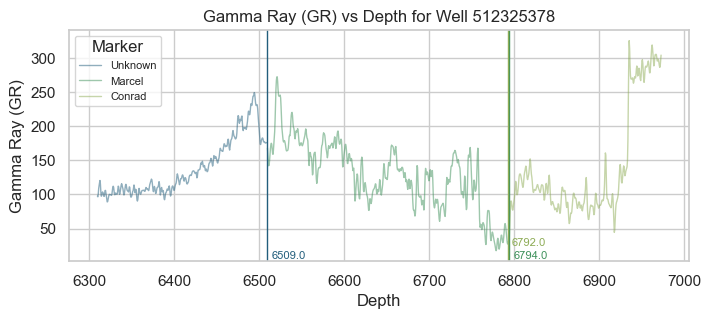

In [7]:
plot_simple(512325378,df_log,df_tops)

### Create Dataset For Training

In [ ]:
#Create dataset for training with window size 200
input_variable = ['GR']
X, y = extract_signature_Xy(df_log,df_tops,well_array, input_variable, wsize=201 )

In [64]:
#Create dataset for training with window size 100
input_variable = ['GR']
X, y = extract_signature_Xy(df_log,df_tops,well_array, input_variable, wsize=101 )

Processing wells:   0%|          | 0/534 [00:00<?, ?it/s]

Data Saved Successfully


In [9]:
#Create dataset for training with window size 50
input_variable = ['GR']
X_50, y_50 = extract_signature_Xy(df_log,df_tops,well_array, input_variable, wsize=51 )

Processing wells:   0%|          | 0/534 [00:00<?, ?it/s]

Data Saved Successfully


In [42]:
#Create dataset for training with window size 50
input_variable = ['GR']
X_50, y_50 = extract_signature_Xy(df_log,df_tops,well_array, input_variable, wsize=21 )

Processing wells:   0%|          | 0/534 [00:00<?, ?it/s]

Data Saved Successfully


### LOAD Testing Data

In [8]:
#Load Testing Data
df_test_log = pd.read_parquet('testdata/logs_50.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400

df_test_loc = pd.read_parquet('testdata/loc_50.parquet', engine='fastparquet')
df_test_loc = df_test_loc.reset_index()

df_test_log = df_test_loc.merge(df_test_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops = pd.read_csv('testdata/tops_50.csv')
df_test_tops = df_test_tops.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops = df_test_tops[cols]

In [9]:
#Load Testing Data 100 WELLS
df_test_log100 = pd.read_parquet('testdata/logs_100.parquet', engine='fastparquet')
df_test_log100.loc[df_test_log100['GR'] < -1, 'GR' ] = -1
df_test_log100.loc[df_test_log100['GR'] > 400, 'GR' ] = 400

df_test_loc100 = pd.read_parquet('testdata/loc_100.parquet', engine='fastparquet')
df_test_loc100 = df_test_loc100.reset_index()

df_test_log100 = df_test_loc100.merge(df_test_log100, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops100 = pd.read_csv('testdata/tops_100.csv')
df_test_tops100 = df_test_tops100.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops100 = df_test_tops100[cols]

In [24]:
gaussian_intervals = apply_fit_distribution(df_tops,well_array,method='gausian',confidence_level=0.99)
stable_intervals = apply_fit_distribution(df_tops,well_array,method='neo-log',confidence_level=0.99)
fft_intervals = apply_fit_distribution(df_tops,well_array,method='fft',confidence_level=0.99)
cauchy_intervals = apply_fit_distribution(df_tops,well_array,method='cauchy',confidence_level=0.99)
fft_cauchy_intervals = apply_fit_distribution(df_tops,well_array,method='cauchy-fft',confidence_level=0.99)

intervals = [gaussian_intervals,stable_intervals,fft_intervals,cauchy_intervals,fft_cauchy_intervals]
methods = ['gausian','neo-log','fft','cauchy','cauchy-fft']

gausian Stable Distribution 🍺 Total Time 6.144273996353149
MARCEL    5900.0 6838.0 (938.0m)
SYLVAIN   6151.0 7010.0 (859.0m)
CONRAD    6189.0 7033.0 (844.0m)
neo-log Stable Distribution 🍺 Total Time 131.51888990402222
MARCEL    5687.0 6705.0 (1018.0m)
SYLVAIN   6050.0 6976.0 (926.0m)
CONRAD    6081.0 6992.0 (912.0m)
fft Stable Distribution 🍺 Total Time 0.04591822624206543
MARCEL    6126.0 6673.0 (548.0m)
SYLVAIN   6363.0 6929.0 (566.0m)
CONRAD    6390.0 6957.0 (568.0m)
cauchy Stable Distribution 🍺 Total Time 0.012888193130493164
MARCEL    1313.0 11554.0 (10241.0m)
SYLVAIN   1313.0 12068.0 (10755.0m)
CONRAD    1237.0 12199.0 (10962.0m)
cauchy-fft Stable Distribution 🍺 Total Time 0.0051610469818115234
MARCEL    313.0 12552.0 (12238.0m)
SYLVAIN   112.0 13257.0 (13145.0m)
CONRAD    -22.0 13441.0 (13463.0m)


### Pyts ROCKET & Improved Pyts ROCKET

In [11]:
import time
from rocket.faster_pyts import Rocket_Faster as ROCKET

#Import For Classification 
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#Import For Testing 
from utils import window, plot_pred_distribution
from utils import get_markers_rocket_order, apply_evaluate
from prediction import apply_fit_distribution,get_markers_rocket_order_with_constraint

from IPython.display import clear_output
import statistics

### Wsize = 200

In [13]:
#Load prepared Dataset
X = np.load('prepared_data/X_201.npy')
y = np.load('prepared_data/y_201.npy')

In [16]:
len(X)

4209

#### FIT & TRANSFORM 

##### Orginal ROCKETS

In [20]:
from sktime.transformations.panel.rocket import Rocket as sktimeROCEKT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

len(X_train)

3367

In [24]:
# ORIGINAL SKTIME
from sktime.transformations.panel.rocket import Rocket as sktimeROCEKT

sktime_rocket = sktimeROCEKT()

## Fit
start = time.time()
sktime_rocket.fit(X_train)
et = time.time() - start
print(f'Fitting time for sktime ROCKET: {et}')

## Transform 
start = time.time()
X_train_transformed = sktime_rocket.transform(X_train)
et = time.time() - start
print(f'Transforming time for sktime ROCKET: {et}')

Fitting time for sktime ROCKET: 0.012722969055175781
Transforming time for sktime ROCKET: 50.66135001182556


In [39]:
# TSAI
from tsai.all import ROCKET as tsaiROCKET
from tsai.all import create_rocket_features
from tsai.data.all import *
from tsai.models.utils import *

tsai_rocket =  tsaiROCKET(c_in =1, seq_len=201)
model = build_ts_model(tsaiROCKET, c_in=1, seq_len=201, n_kernels=10000)

#Fit 
start = time.time()
tfms = [None, TSRegression()]
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X_train_reshaped, y_train,tfms=tfms, batch_tfms=batch_tfms,shuffle_train=False, drop_last=False)
et = time.time() - start
print(f'Fitting time for tsai ROCKET: {et}')

## Transform 
start = time.time()
X_train_transformed, _= create_rocket_features(dls.train, model) 
et = time.time() - start
print(f'Transforming time for tsai ROCKET: {et}')

Fitting time for tsai ROCKET: 0.048426151275634766
Transforming time for tsai ROCKET: 284.8413739204407


In [38]:
# Original PYTS
from pyts.transformation import ROCKET as pytsROCKET
pyts_rocket = pytsROCKET(n_kernels=10000)

## Fit --> reduced time for fitting 
start = time.time()
pyts_rocket.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for pyts ROCKET: {et}')

## Transform --> reduced time for transforming 
start = time.time()
X_train_transformed_pyts = pyts_rocket.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for pyts ROCKET: {et}')

Fitting time for pyts ROCKET: 2.007474184036255
Transforming time for pyts ROCKET: 38.477526903152466


##### Faster ROCKETS

In [14]:
# ONLY RUN THIS CELL IF YOU WANT TO USE WSIZE 200
#Split into Train & Validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

rocket_faster = ROCKET(n_kernels=10000)

## Fit --> reduced time for fitting 
start = time.time()
rocket_faster.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for faster ROCKET: {et}')

## Transform --> reduced time for transforming 
start = time.time()
X_train_transformed = rocket_faster.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for faster ROCKET: {et}')

#transform X_test
X_test = X_test.reshape(X_test.shape[0], -1)
X_test_transformed = rocket_faster.transform(X_test)


Fitting time for faster ROCKET: 1.3779351711273193
Transforming time for faster ROCKET: 8.657728910446167


#### Traditional Classification with the Fast ROCKET (TRAIN & VALIDATION)

In [16]:
#Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transformed, y_train)

classifier.score(X_test_transformed, y_test)

 #XGBoost classifier
eps = 1e-6

# normalize 'per feature'
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps
X_train_norm = (X_train_transformed - f_mean) / f_std
X_valid_norm = (X_test_transformed - f_mean) / f_std
print(X_train_norm.shape)

classifier_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb.fit(X_train_norm, y_train)
preds = classifier_xgb.predict(X_valid_norm)

(preds == y_test).mean()

##logistic regression

eps = 1e-6
C = 1e-2
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps  # epsilon to avoid dividing by 0
X_train_tfm2 = (X_train_transformed - f_mean) / f_std
X_valid_tfm2 = (X_test_transformed - f_mean) / f_std
classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier.fit(X_train_tfm2, y_train)
probas = classifier.predict_proba(X_train_tfm2)
train_score = classifier.score(X_train_tfm2, y_train)
val_score = classifier.score(X_valid_tfm2, y_test)
print('{:2} eps: {:.2E}  C: {:.2E}   train_acc: {:.5f}  valid_acc: {:.5f}'.format(1, eps, C, train_score, val_score))

(3367, 20000)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 1 eps: 1.00E-06  C: 1.00E-02   train_acc: 0.99822  valid_acc: 0.99169


In [27]:
optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)

tolerance 20, recall 0.9733333333333334, mae 3.986666666666667
tolerance 15, recall 0.9733333333333334, mae 3.986666666666667
tolerance 10, recall 0.92, mae 3.986666666666667
tolerance 5, recall 0.8066666666666666, mae 3.986666666666667
Largest Error MARCEL: 27.0
Largest Error SYLVAIN: 12.0
Largest Error CONRAD: 36.0
🍺 Optimal Tolerance : 36


In [30]:
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(rocket_faster,interval,df_test_tops,df_test_log, use_constraint=True)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)
    print("- -"*20)

😈gausian😈


Processing Wells: 100%|██████████| 50/50 [12:03<00:00, 14.47s/it]


🍺 Total prediction time 723.5571310520172
tolerance 20, recall 0.9733333333333334, mae 3.986666666666667
tolerance 15, recall 0.9733333333333334, mae 3.986666666666667
tolerance 10, recall 0.92, mae 3.986666666666667
tolerance 5, recall 0.8066666666666666, mae 3.986666666666667
Largest Error MARCEL: 27.0
Largest Error SYLVAIN: 12.0
Largest Error CONRAD: 36.0
🍺 Optimal Tolerance : 36
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈neo-log😈


Processing Wells: 100%|██████████| 50/50 [14:42<00:00, 17.65s/it]


🍺 Total prediction time 882.5449869632721
tolerance 20, recall 0.9733333333333334, mae 3.986666666666667
tolerance 15, recall 0.9733333333333334, mae 3.986666666666667
tolerance 10, recall 0.92, mae 3.986666666666667
tolerance 5, recall 0.8066666666666666, mae 3.986666666666667
Largest Error MARCEL: 27.0
Largest Error SYLVAIN: 12.0
Largest Error CONRAD: 36.0
🍺 Optimal Tolerance : 36
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈fft😈


Processing Wells: 100%|██████████| 50/50 [13:30<00:00, 16.20s/it]


🍺 Total prediction time 810.1569590568542
tolerance 20, recall 0.94, mae 8.153333333333334
tolerance 15, recall 0.94, mae 8.153333333333334
tolerance 10, recall 0.8866666666666667, mae 8.153333333333334
tolerance 5, recall 0.7933333333333333, mae 8.153333333333334
Largest Error MARCEL: 56.0
Largest Error SYLVAIN: 193.0
Largest Error CONRAD: 198.0
🍺 Optimal Tolerance : 198
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy😈


Processing Wells: 100%|██████████| 50/50 [13:13<00:00, 15.87s/it]


🍺 Total prediction time 793.3598039150238
tolerance 20, recall 0.9666666666666667, mae 13.926666666666666
tolerance 15, recall 0.9666666666666667, mae 13.926666666666666
tolerance 10, recall 0.9133333333333333, mae 13.926666666666666
tolerance 5, recall 0.8, mae 13.926666666666666
Largest Error MARCEL: 27.0
Largest Error SYLVAIN: 770.0
Largest Error CONRAD: 747.0
🍺 Optimal Tolerance : 770
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy-fft😈


Processing Wells: 100%|██████████| 50/50 [21:34<00:00, 25.89s/it]


🍺 Total prediction time 1294.4762332439423
tolerance 20, recall 0.9666666666666667, mae 13.926666666666666
tolerance 15, recall 0.9666666666666667, mae 13.926666666666666
tolerance 10, recall 0.9133333333333333, mae 13.926666666666666
tolerance 5, recall 0.8, mae 13.926666666666666
Largest Error MARCEL: 27.0
Largest Error SYLVAIN: 770.0
Largest Error CONRAD: 747.0
🍺 Optimal Tolerance : 770
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


#### Sktime Faster

In [16]:
from rocket.sktime_rocket.my_rocket import Rocket as faster_sktime

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sktime_rocket = faster_sktime()

## Fit
start = time.time()
sktime_rocket.fit(X_train)
et = time.time() - start
print(f'Fitting time for sktime ROCKET: {et}')

## Transform 
start = time.time()
X_train_transformed = sktime_rocket.transform(X_train)
et = time.time() - start
print(f'Transforming time for sktime ROCKET: {et}')

#transform X_test
X_test_transformed = sktime_rocket.transform(X_test)

Fitting time for sktime ROCKET: 0.011395931243896484
Transforming time for sktime ROCKET: 6.516602039337158


In [22]:
#Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transformed, y_train)

classifier.score(X_test_transformed, y_test)

 #XGBoost classifier
eps = 1e-6

# normalize 'per feature'
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps
X_train_norm = (X_train_transformed - f_mean) / f_std
X_valid_norm = (X_test_transformed - f_mean) / f_std
print(X_train_norm.shape)

classifier_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb.fit(X_train_norm, y_train)
preds = classifier_xgb.predict(X_valid_norm)

(preds == y_test).mean()

##logistic regression

eps = 1e-6
C = 1e-2
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps  # epsilon to avoid dividing by 0
X_train_tfm2 = (X_train_transformed - f_mean) / f_std
X_valid_tfm2 = (X_test_transformed - f_mean) / f_std
classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier.fit(X_train_tfm2, y_train)
probas = classifier.predict_proba(X_train_tfm2)
train_score = classifier.score(X_train_tfm2, y_train)
val_score = classifier.score(X_valid_tfm2, y_test)
print('{:2} eps: {:.2E}  C: {:.2E}   train_acc: {:.5f}  valid_acc: {:.5f}'.format(1, eps, C, train_score, val_score))

(3367, 20000)
 1 eps: 1.00E-06  C: 1.00E-02   train_acc: 1.00000  valid_acc: 1.00000


In [23]:
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
for i,interval in enumerate(intervals):
    print(f"😈{methods[i]}😈")
    df_tops_pred = run_prediction(sktime_rocket,interval,df_test_tops,df_test_log, use_constraint=True)
    optimal_tolerance, df_result = apply_evaluate(df_test_tops,df_tops_pred)
    print("- -"*20)

😈gausian😈


Processing Wells: 100%|██████████| 50/50 [11:01<00:00, 13.22s/it]


🍺 Total prediction time 661.2056729793549
tolerance 20, recall 0.9866666666666667, mae 3.546666666666667
tolerance 15, recall 0.9666666666666667, mae 3.546666666666667
tolerance 10, recall 0.9466666666666667, mae 3.546666666666667
tolerance 5, recall 0.84, mae 3.546666666666667
Largest Error MARCEL: 41.5
Largest Error SYLVAIN: 16.0
Largest Error CONRAD: 39.0
🍺 Optimal Tolerance : 42
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈neo-log😈


Processing Wells: 100%|██████████| 50/50 [10:54<00:00, 13.10s/it]


🍺 Total prediction time 654.9506449699402
tolerance 20, recall 0.9466666666666667, mae 12.726666666666667
tolerance 15, recall 0.9266666666666666, mae 12.726666666666667
tolerance 10, recall 0.9066666666666666, mae 12.726666666666667
tolerance 5, recall 0.8133333333333334, mae 12.726666666666667
Largest Error MARCEL: 612.0
Largest Error SYLVAIN: 225.0
Largest Error CONRAD: 54.0
🍺 Optimal Tolerance : 612
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈fft😈


Processing Wells: 100%|██████████| 50/50 [10:53<00:00, 13.07s/it]


🍺 Total prediction time 653.3821310997009
tolerance 20, recall 0.9666666666666667, mae 6.51
tolerance 15, recall 0.9466666666666667, mae 6.51
tolerance 10, recall 0.9266666666666666, mae 6.51
tolerance 5, recall 0.8333333333333334, mae 6.51
Largest Error MARCEL: 406.0
Largest Error SYLVAIN: 28.0
Largest Error CONRAD: 39.0
🍺 Optimal Tolerance : 406
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy😈


Processing Wells: 100%|██████████| 50/50 [10:54<00:00, 13.10s/it]


🍺 Total prediction time 654.9477410316467
tolerance 20, recall 0.9866666666666667, mae 3.546666666666667
tolerance 15, recall 0.9666666666666667, mae 3.546666666666667
tolerance 10, recall 0.9466666666666667, mae 3.546666666666667
tolerance 5, recall 0.84, mae 3.546666666666667
Largest Error MARCEL: 41.5
Largest Error SYLVAIN: 16.0
Largest Error CONRAD: 39.0
🍺 Optimal Tolerance : 42
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
😈cauchy-fft😈


Processing Wells: 100%|██████████| 50/50 [10:54<00:00, 13.09s/it]

🍺 Total prediction time 654.2558770179749
tolerance 20, recall 0.9866666666666667, mae 3.546666666666667
tolerance 15, recall 0.9666666666666667, mae 3.546666666666667
tolerance 10, recall 0.9466666666666667, mae 3.546666666666667
tolerance 5, recall 0.84, mae 3.546666666666667
Largest Error MARCEL: 41.5
Largest Error SYLVAIN: 16.0
Largest Error CONRAD: 39.0
🍺 Optimal Tolerance : 42
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -


#### Testing

Prediction:[6466, 7362, 6644]
Real:[6460.0, 6592.0, 6620.0]


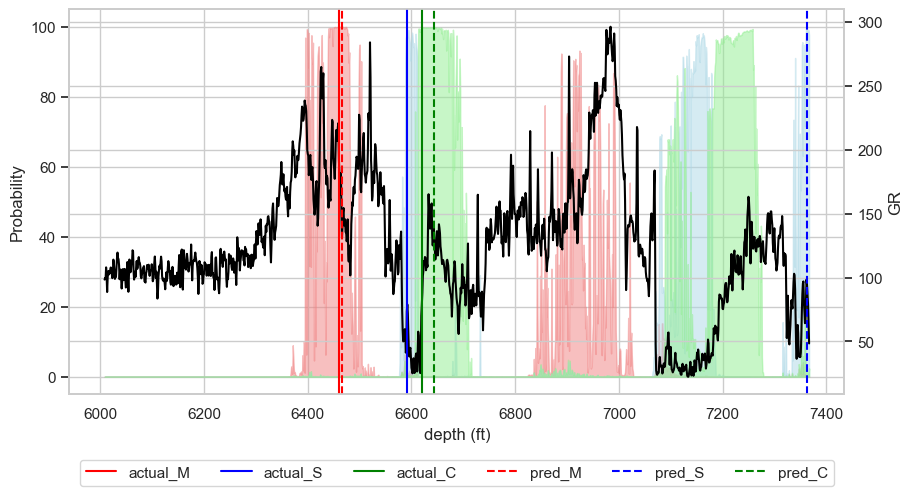

In [17]:
# Example Testing with one well before start process prediciton on the entire testing dataset

df_tops = df_tops[df_tops.index.isin(well_array[0][0])]

wsize = 201 #adjust as needed
well = 512322535
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']

#Predict Marker Depth without Constraint 
pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier,xgb = True)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)

Error in the training data:<br>
The order of the starting depth of different type of soil(marker) does not follow the logical facts[MARCEL-SYLVAIN-CONARD]<br>
But for the two given wells, the depth of CONRAD is higher than the depth of SYLVAIN, whereas it should be found below SYLVAIN. <br>
***Thus we will apply a Constraint to the prediciton.***

Prediction:[6461.0, 6599.0, 6623.0]
Real:[6460.0, 6592.0, 6620.0]


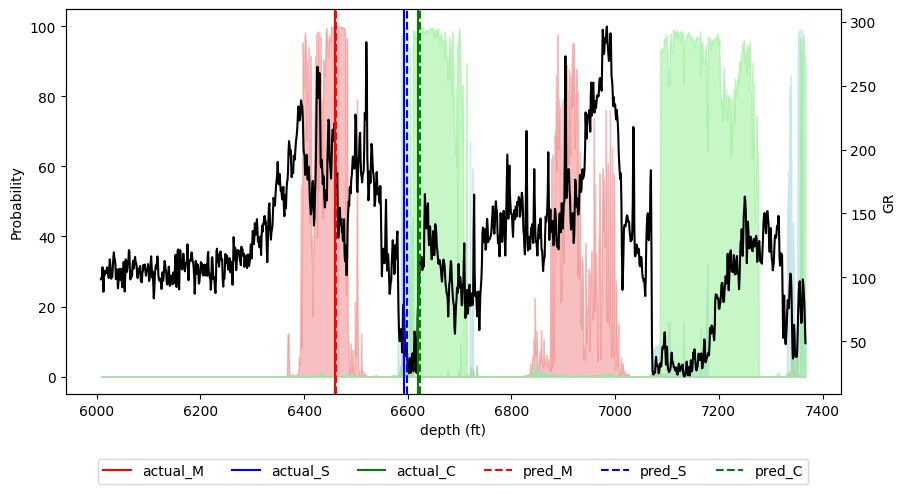

In [99]:
#Predict Marker Depth with Constraint 
pred_m, df_wm = get_markers_rocket_order_with_constraint(f_mean, f_std,df_tops, df_test_log, well, pred_column, wsize, input_variable, 
                                             s2s = False,
                                             model = None, 
                                             xgb = True,
                                             rocket = rocket_faster, 
                                             classifier_xgb = classifier_xgb, 
                                             classifier = classifier,
                                             alpha=0.5, 
                                             confidence_level=0.96)
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)

In [104]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 659.4394600391388


In [105]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.98, mae 43.02333333333333
tolerance 15, recall 0.98, mae 43.02333333333333
tolerance 10, recall 0.9666666666666667, mae 43.02333333333333
tolerance 5, recall 0.8266666666666667, mae 43.02333333333333
Largest Error MARCEL: 31.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 5985.0
Optimal Tolerance : 5985


In [102]:
#Predict ALL WITH CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order_with_constraint(f_mean, f_std,df_tops, df_test_log, well, pred_column, wsize, input_variable, 
                                             s2s = False,
                                             model = None, 
                                             xgb = True,
                                             rocket = rocket_faster, 
                                             classifier_xgb = classifier_xgb, 
                                             classifier = classifier,
                                             alpha=0.5, 
                                             confidence_level=0.96)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 777.3081321716309


In [103]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.98, mae 3.643733333333348
tolerance 15, recall 0.9733333333333334, mae 3.643733333333348
tolerance 10, recall 0.9466666666666667, mae 3.643733333333348
tolerance 5, recall 0.8, mae 3.643733333333348
Largest Error MARCEL: 31.0
Largest Error SYLVAIN: 30.340000000000146
Largest Error CONRAD: 13.700000000000728
Optimal Tolerance : 31


### Wsize = 100

In [143]:
#Load prepared Dataset
X = np.load('prepared_data/X_201.npy')
y = np.load('prepared_data/y_201.npy')

In [152]:
len(X)/12

350.75

#### FIT & TRANSFORM

In [22]:
#Split into Train & Validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

rocket_faster = ROCKET()
pyts_rocket = pytsROCKET()

## Fit --> reduced time for fitting 
start = time.time()
rocket_faster.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for faster ROCKET: {et}')

start = time.time()
pyts_rocket.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for pyts ROCKET: {et}')

## Transform --> reduced time for transforming 
start = time.time()
X_train_transformed = rocket_faster.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for faster ROCKET: {et}')

start = time.time()
X_train_transformed_pyts = pyts_rocket.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for pyts ROCKET: {et}')

#transform X_test
X_test = X_test.reshape(X_test.shape[0], -1)
X_test_transformed = rocket_faster.transform(X_test)

Fitting time for faster ROCKET: 0.013289928436279297
Fitting time for pyts ROCKET: 0.007931947708129883
Transforming time for faster ROCKET: 3.778454065322876
Transforming time for pyts ROCKET: 23.94534397125244


#### Fit & Transform for Wsize = 50

In [4]:
# ONLY RUN THIS CELL IF YOU WANT TO USE WSIZE 50
#Split into Train & Validation 
X_train, X_test, y_train, y_test = train_test_split(X_50, y_50, test_size=0.2, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

rocket_faster = ROCKET()
pyts_rocket = pytsROCKET()

## Fit --> reduced time for fitting 
start = time.time()
rocket_faster.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for faster ROCKET: {et}')

start = time.time()
pyts_rocket.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for pyts ROCKET: {et}')

## Transform --> reduced time for transforming 
start = time.time()
X_train_transformed = rocket_faster.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for faster ROCKET: {et}')

start = time.time()
X_train_transformed_pyts = pyts_rocket.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for pyts ROCKET: {et}')

#transform X_test
X_test = X_test.reshape(X_test.shape[0], -1)
X_test_transformed = rocket_faster.transform(X_test)


Fitting time for faster ROCKET: 1.0264039039611816
Fitting time for pyts ROCKET: 1.2617368698120117
Transforming time for faster ROCKET: 3.808624029159546
Transforming time for pyts ROCKET: 14.15451717376709


#### Traditional Classification with the Fast ROCKET (TRAIN & VALIDATION)

In [23]:
#Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transformed, y_train)

classifier.score(X_test_transformed, y_test)

#XGBoost classifier
eps = 1e-6

# normalize 'per feature'
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps
X_train_norm = (X_train_transformed - f_mean) / f_std
X_valid_norm = (X_test_transformed - f_mean) / f_std
print(X_train_norm.shape)

classifier_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb.fit(X_train_norm, y_train)
preds = classifier_xgb.predict(X_valid_norm)

print((preds == y_test).mean())

##logistic regression

eps = 1e-6
C = 1e-2
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps  # epsilon to avoid dividing by 0
X_train_tfm2 = (X_train_transformed - f_mean) / f_std
X_valid_tfm2 = (X_test_transformed - f_mean) / f_std
classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier.fit(X_train_tfm2, y_train)
probas = classifier.predict_proba(X_train_tfm2)
train_score = classifier.score(X_train_tfm2, y_train)
val_score = classifier.score(X_valid_tfm2, y_test)
print('{:2} eps: {:.2E}  C: {:.2E}   train_acc: {:.5f}  valid_acc: {:.5f}'.format(1, eps, C, train_score, val_score))

(3369, 20000)
0.9988137603795967


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 1 eps: 1.00E-06  C: 1.00E-02   train_acc: 0.99970  valid_acc: 0.99763


#### Testing

In [25]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 101
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 450.959801197052


In [26]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9733333333333334, mae 3.7133333333333334
tolerance 15, recall 0.9733333333333334, mae 3.7133333333333334
tolerance 10, recall 0.9666666666666667, mae 3.7133333333333334
tolerance 5, recall 0.9333333333333333, mae 3.7133333333333334
Largest Error MARCEL: 123.0
Largest Error SYLVAIN: 24.0
Largest Error CONRAD: 9.0
Optimal Tolerance : 123


In [28]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 101
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order_with_constraints(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 451.16542172431946


In [29]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9733333333333334, mae 3.7133333333333334
tolerance 15, recall 0.9733333333333334, mae 3.7133333333333334
tolerance 10, recall 0.9666666666666667, mae 3.7133333333333334
tolerance 5, recall 0.9333333333333333, mae 3.7133333333333334
Largest Error MARCEL: 123.0
Largest Error SYLVAIN: 24.0
Largest Error CONRAD: 9.0
Optimal Tolerance : 123


### Wsize = 50

In [60]:
#Load prepared Dataset
X = np.load('prepared_data/X_51.npy')
y = np.load('prepared_data/y_51.npy')

#### FIT & TRANSFORM

In [61]:
#Split into Train & Validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

rocket_faster = ROCKET()
pyts_rocket = pytsROCKET()

## Fit --> reduced time for fitting 
start = time.time()
rocket_faster.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for faster ROCKET: {et}')

start = time.time()
pyts_rocket.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for pyts ROCKET: {et}')

## Transform --> reduced time for transforming 
start = time.time()
X_train_transformed = rocket_faster.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for faster ROCKET: {et}')

start = time.time()
X_train_transformed_pyts = pyts_rocket.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for pyts ROCKET: {et}')

#transform X_test
X_test = X_test.reshape(X_test.shape[0], -1)
X_test_transformed = rocket_faster.transform(X_test)

Fitting time for faster ROCKET: 0.026220083236694336
Fitting time for pyts ROCKET: 0.033720970153808594
Transforming time for faster ROCKET: 3.076735019683838
Transforming time for pyts ROCKET: 17.894952058792114


#### Traditional Classification with the Fast ROCKET (TRAIN & VALIDATION)

In [62]:
#Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transformed, y_train)

classifier.score(X_test_transformed, y_test)

#XGBoost classifier
eps = 1e-6

# normalize 'per feature'
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps
X_train_norm = (X_train_transformed - f_mean) / f_std
X_valid_norm = (X_test_transformed - f_mean) / f_std
print(X_train_norm.shape)

classifier_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb.fit(X_train_norm, y_train)
preds = classifier_xgb.predict(X_valid_norm)

print((preds == y_test).mean())

##logistic regression

eps = 1e-6
C = 1e-2
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps  # epsilon to avoid dividing by 0
X_train_tfm2 = (X_train_transformed - f_mean) / f_std
X_valid_tfm2 = (X_test_transformed - f_mean) / f_std
classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier.fit(X_train_tfm2, y_train)
probas = classifier.predict_proba(X_train_tfm2)
train_score = classifier.score(X_train_tfm2, y_train)
val_score = classifier.score(X_valid_tfm2, y_test)
print('{:2} eps: {:.2E}  C: {:.2E}   train_acc: {:.5f}  valid_acc: {:.5f}'.format(1, eps, C, train_score, val_score))

(3369, 20000)
0.9893238434163701


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 1 eps: 1.00E-06  C: 1.00E-02   train_acc: 0.99822  valid_acc: 0.99288


#### Testing

In [35]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 51
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 348.1744656562805


In [36]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.96, mae 4.8966666666666665
tolerance 15, recall 0.96, mae 4.8966666666666665
tolerance 10, recall 0.9333333333333333, mae 4.8966666666666665
tolerance 5, recall 0.9133333333333333, mae 4.8966666666666665
Largest Error MARCEL: 117.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 10.0
Optimal Tolerance : 117


### Mix_Wsize(200 & 50)

In [23]:
#Load prepared Dataset
X_200 = np.load('prepared_data/X_201.npy')
y_200 = np.load('prepared_data/y_201.npy')

X_50 = np.load('prepared_data/X_51.npy')
y_50 = np.load('prepared_data/y_51.npy')

In [24]:
#Split X_200 y_200 into Train & Validation 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_200, y_200, test_size=0.2, random_state=42)
X_train_reshaped1 = X_train1.reshape(X_train1.shape[0], -1)

rocket_faster1 = ROCKET()
rocket_faster1.fit(X_train_reshaped1)
X_train_transformed1 = rocket_faster1.transform(X_train_reshaped1)

#Split X_50 y_50 into Train & Validation 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_50, y_50, test_size=0.2, random_state=42)
X_train_reshaped2 = X_train2.reshape(X_train2.shape[0], -1)

rocket_faster2 = ROCKET()
rocket_faster2.fit(X_train_reshaped2)
X_train_transformed2 = rocket_faster2.transform(X_train_reshaped2)

In [25]:
#Classifier For Wsize200

eps = 1e-6
C = 1e-2
# normalize 'per feature'
f_mean1 = X_train_transformed1.mean(axis=0)
f_std1 = X_train_transformed1.std(axis=0) + eps
X_train_norm1 = (X_train_transformed1 - f_mean1) / f_std1

#XGBoost classifier
classifier_xgb1 = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb1.fit(X_train_norm1, y_train1)

##logistic regression
classifier1 = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier1.fit(X_train_norm1, y_train1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01, n_jobs=-1)

In [26]:
#Classifier For Wsize50

# normalize 'per feature'
f_mean2 = X_train_transformed2.mean(axis=0)
f_std2 = X_train_transformed2.std(axis=0) + eps
X_train_norm2 = (X_train_transformed2 - f_mean2) / f_std2

#XGBoost classifier
classifier_xgb2 = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb2.fit(X_train_norm2, y_train2)

##logistic regression
classifier2 = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier2.fit(X_train_norm2, y_train2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01, n_jobs=-1)

[6464, 7367, 6624]
[6464, 6595, 6619]
Prediction:[6464, 6595, 6619]
Real:[6460.0, 6592.0, 6620.0]


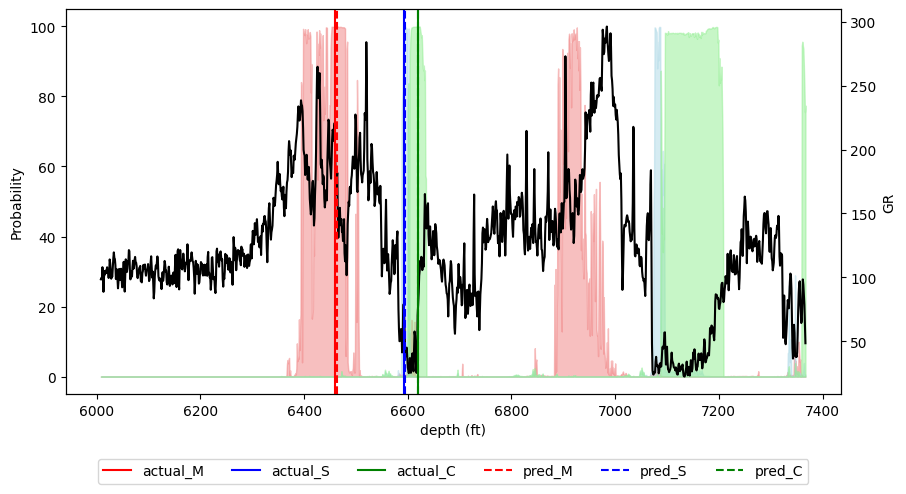

In [27]:
# Example Testing with one well before start process prediciton on the entire testing dataset

wsize1 = 201 
wsize2 = 51
well = 512322535
input_variable=['GR']
pred_column = ['None','Marcel','Sylvian', 'Conrad']

#Predict Marker Depth without Constraint 
pred_m1, df_wm1 = get_markers_rocket_order(f_mean1, f_std1, df_test_log, well, pred_column, wsize1, input_variable, rocket_faster1, classifier_xgb1, classifier1, xgb = True)
pred_m2, df_wm2 = get_markers_rocket_order(f_mean2, f_std2, df_test_log, well, pred_column, wsize2, input_variable, rocket_faster2, classifier_xgb2, classifier2, xgb = True)
print(pred_m1)
print(pred_m2)
pred_m = [pred_m1[0]] + pred_m2[1:3]
df_wm = df_wm1[['GR','Depth','None','Marcel']].merge(df_wm2[['Depth','Sylvian','Conrad']],how='left',on='Depth')
td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)

In [15]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize1 = 201
wsize2 = 51
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvain', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m1, df_wm1 = get_markers_rocket_order(f_mean1, f_std1, df_test_log, well, pred_column, wsize1, input_variable, rocket_faster1, classifier_xgb1, classifier1, xgb = True)
    pred_m2, df_wm2 = get_markers_rocket_order(f_mean2, f_std2, df_test_log, well, pred_column, wsize2, input_variable, rocket_faster2, classifier_xgb2, classifier2, xgb = True)
    pred_m = [pred_m1[0]] + pred_m2[1:3]
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 1031.0859670639038


In [22]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9866666666666667, mae 2.6433333333333335
tolerance 15, recall 0.9866666666666667, mae 2.6433333333333335
tolerance 10, recall 0.9666666666666667, mae 2.6433333333333335
tolerance 5, recall 0.9066666666666666, mae 2.6433333333333335
Largest Error MARCEL: 29.0
Largest Error SYLVAIN: 11.0
Largest Error CONRAD: 8.0
Optimal Tolerance : 29
